In [1]:
import os
import logging
from typing import List, Optional
import wandb

import pandas as pd

import torch

from nll_to_po.models.dn_policy import MLPPolicy
from nll_to_po.training.utils import train_single_policy, setup_logger
import nll_to_po.training.loss as L
import nll_to_po.training.reward as R

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
os.environ["WANDB_SILENT"] = "true"  # Suppress WandB output

<Figure size 640x480 with 0 Axes>

### config

In [2]:
df_list: list[pd.DataFrame] = []

In [22]:
# Experiment parameters
n_experiments: int = 10
n_updates: int = 100
learning_rate: float = 0.001
use_wandb: bool = False
wandb_project: str = "tractable"

# Policy architecture
input_dim: int = 4
output_dim: int = 2
hidden_sizes: list[int] = [64, 64]
fixed_logstd: bool = False

# Data generating dist q
init_dist_loc: float = 5.0
init_dist_scale: float = 0.75
init_dist_n_samples: int = 10

### MSE

In [23]:
for exp_idx in range(n_experiments):
    policy = MLPPolicy(input_dim, output_dim, hidden_sizes, fixed_logstd)

    # Generate new random data for each experiment
    X = torch.randn(1, input_dim)
    mean_y = torch.ones((1, output_dim)) * init_dist_loc
    y = mean_y + torch.randn(init_dist_n_samples, output_dim) * init_dist_scale
    X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample
    batch_size = X.shape[0]

    # Create a DataLoader
    train_dataset = torch.utils.data.TensorDataset(X, y)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    # Define the loss function
    loss_function = L.MSE()

    config = {
        "batch_size": batch_size,
        "fixed_logstd": fixed_logstd,
        "init_dist_loc": init_dist_loc,
        "init_dist_scale": init_dist_scale,
        "init_dist_n_samples": init_dist_n_samples,
        "learning_rate": learning_rate,
        "loss_type": loss_function.name,
    }
    if use_wandb:
        wandb_run = wandb.init(
            project=wandb_project,
            config=config,
        )
    else:
        wandb_run = None
    logger, _, ts_writer = setup_logger(
        logger_name="nll_to_po",
        log_dir="../logs",
        env_id="test_theory",
        exp_name=f"{loss_function.name}_{exp_idx}",
    )
    # Log the configuration
    logger.info(f"%%%%%%%%%%%%%%%%%%%\nconfig:\n{config}\n%%%%%%%%%%%%%%%%%%%%")

    # Run comparison
    _, mse_train_metrics, _ = train_single_policy(
        policy=policy,
        train_dataloader=train_dataloader,
        loss_function=loss_function,
        n_updates=n_updates,
        learning_rate=learning_rate,
        wandb_run=wandb_run,
        tensorboard_writer=ts_writer,
        logger=logger,
    )

    if use_wandb:
        wandb_run.finish()

    # Save to dataframe
    df = pd.DataFrame(mse_train_metrics).reset_index()
    df = df.rename(columns={"index": "epoch"})
    for k, v in config.items():
        df[k] = v
    df["experiment"] = exp_idx

    df_list.append(df)

2025-08-14 12:46:58 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'batch_size': 10, 'fixed_logstd': False, 'init_dist_loc': 5.0, 'init_dist_scale': 0.75, 'init_dist_n_samples': 10, 'learning_rate': 0.001, 'loss_type': 'MSE'}
%%%%%%%%%%%%%%%%%%%%
2025-08-14 12:46:58 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training epochs: 100%|██████████| 100/100 [00:00<00:00, 475.34it/s]
2025-08-14 12:46:59 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'batch_size': 10, 'fixed_logstd': False, 'init_dist_loc': 5.0, 'init_dist_scale': 0.75, 'init_dist_n_samples': 10, 'learning_rate': 0.001, 'loss_type': 'MSE'}
%%%%%%%%%%%%%%%%%%%%
2025-08-14 12:46:59 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 490.12it/s]
2025-08-14 12:46:59 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'batch_size': 10, 'fixed_logstd': False, 'init_dist_loc': 5.0, 'init_dist_scale': 0.75, 'init_dist_n_samples': 10, 'learning_rate': 0.001, 'loss_type': 'MSE'}
%%%%%%%%%%%%%%%%%%%%
2025-08-14 12:46:59 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 499.98it/s]
2025-08-14 12:46:59 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'batch_size': 10, 'fixed_logstd': False, 'init_dist_loc': 5.0, 'init_dist_scal

### NLL

In [24]:
for exp_idx in range(n_experiments):
    policy = MLPPolicy(input_dim, output_dim, hidden_sizes, fixed_logstd)

    # Generate new random data for each experiment
    X = torch.randn(1, input_dim)
    mean_y = torch.ones((1, output_dim)) * init_dist_loc
    y = mean_y + torch.randn(init_dist_n_samples, output_dim) * init_dist_scale
    X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample
    batch_size = X.shape[0]

    # Create a DataLoader
    train_dataset = torch.utils.data.TensorDataset(X, y)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    # Define the loss function
    loss_function = L.NLL()

    config = {
        "batch_size": batch_size,
        "fixed_logstd": fixed_logstd,
        "init_dist_loc": init_dist_loc,
        "init_dist_scale": init_dist_scale,
        "init_dist_n_samples": init_dist_n_samples,
        "learning_rate": learning_rate,
        "loss_type": loss_function.name,
    }
    if use_wandb:
        wandb_run = wandb.init(
            project=wandb_project,
            config=config,
        )
    else:
        wandb_run = None
    logger, _, ts_writer = setup_logger(
        logger_name="nll_to_po",
        log_dir="../logs",
        env_id="test_theory",
        exp_name=f"{loss_function.name}_{exp_idx}",
    )
    # Log the configuration
    logger.info(f"%%%%%%%%%%%%%%%%%%%\nconfig:\n{config}\n%%%%%%%%%%%%%%%%%%%%")

    # Run comparison
    _, nll_train_metrics, _ = train_single_policy(
        policy=policy,
        train_dataloader=train_dataloader,
        loss_function=loss_function,
        n_updates=n_updates,
        learning_rate=learning_rate,
        wandb_run=wandb_run,
        tensorboard_writer=ts_writer,
        logger=logger,
    )

    if use_wandb:
        wandb_run.finish()

    # Save to dataframe
    df = pd.DataFrame(nll_train_metrics).reset_index()
    df = df.rename(columns={"index": "epoch"})
    for k, v in config.items():
        df[k] = v
    df["experiment"] = exp_idx

    df_list.append(df)

2025-08-14 12:47:00 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'batch_size': 10, 'fixed_logstd': False, 'init_dist_loc': 5.0, 'init_dist_scale': 0.75, 'init_dist_n_samples': 10, 'learning_rate': 0.001, 'loss_type': 'NLL'}
%%%%%%%%%%%%%%%%%%%%
2025-08-14 12:47:00 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 485.47it/s]
2025-08-14 12:47:01 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'batch_size': 10, 'fixed_logstd': False, 'init_dist_loc': 5.0, 'init_dist_scale': 0.75, 'init_dist_n_samples': 10, 'learning_rate': 0.001, 'loss_type': 'NLL'}
%%%%%%%%%%%%%%%%%%%%
2025-08-14 12:47:01 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 498.78it/s]
2025-08-14 12:47:01 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'batch_size': 10, 'fixed_logstd': False, 'init_dist_loc': 5.0, 'init_dist_scale': 0.75, 'init_dist_n_samples': 10, 'learning_rate': 0.001, 'loss_t

### PG

In [25]:
n_generations = 5
use_rsample = False
reward_transform = "normalize"

for _ in range(n_experiments):
    policy = MLPPolicy(input_dim, output_dim, hidden_sizes, fixed_logstd)

    # Generate new random data for each experiment
    X = torch.randn(1, input_dim)
    mean_y = torch.ones((1, output_dim)) * init_dist_loc
    y = mean_y + torch.randn(init_dist_n_samples, output_dim) * init_dist_scale
    X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample
    batch_size = X.shape[0]

    # Create a DataLoader
    train_dataset = torch.utils.data.TensorDataset(X, y)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    # Define reward function
    reward_fn = R.Mahalanobis(matrix=torch.eye(output_dim))

    # Define the loss function
    loss_function = L.PO(
        reward_fn=reward_fn,
        n_generations=n_generations,
        use_rsample=use_rsample,
        reward_transform=reward_transform,
    )

    config = {
        "batch_size": batch_size,
        "fixed_logstd": fixed_logstd,
        "init_dist_loc": init_dist_loc,
        "init_dist_scale": init_dist_scale,
        "init_dist_n_samples": init_dist_n_samples,
        "learning_rate": learning_rate,
        "loss_type": loss_function.name,
        "n_generations": n_generations,
        "use_rsample": use_rsample,
        "reward_transform": reward_transform,
    }

    if use_wandb:
        wandb_run = wandb.init(
            project=wandb_project,
            config=config,
        )
    else:
        wandb_run = None
    logger, _, ts_writer = setup_logger(
        logger_name="nll_to_po",
        log_dir="../logs",
        env_id="test_theory",
        exp_name=f"{loss_function.name}_{exp_idx}",
    )
    # Log the configuration
    logger.info(f"%%%%%%%%%%%%%%%%%%%\nconfig:\n{config}\n%%%%%%%%%%%%%%%%%%%%")

    # Run comparison
    _, po_train_metrics, _ = train_single_policy(
        policy=policy,
        train_dataloader=train_dataloader,
        loss_function=loss_function,
        n_updates=n_updates,
        learning_rate=learning_rate,
        wandb_run=wandb_run,
        tensorboard_writer=ts_writer,
        logger=logger,
    )

    if use_wandb:
        wandb_run.finish()

    # Save to dataframe
    df = pd.DataFrame(po_train_metrics).reset_index()
    df = df.rename(columns={"index": "epoch"})
    for k, v in config.items():
        df[k] = v
    df["experiment"] = exp_idx

    df_list.append(df)

2025-08-14 12:47:03 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'batch_size': 10, 'fixed_logstd': False, 'init_dist_loc': 5.0, 'init_dist_scale': 0.75, 'init_dist_n_samples': 10, 'learning_rate': 0.001, 'loss_type': 'PO', 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'normalize'}
%%%%%%%%%%%%%%%%%%%%
2025-08-14 12:47:03 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training epochs: 100%|██████████| 100/100 [00:00<00:00, 431.88it/s]
2025-08-14 12:47:03 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'batch_size': 10, 'fixed_logstd': False, 'init_dist_loc': 5.0, 'init_dist_scale': 0.75, 'init_dist_n_samples': 10, 'learning_rate': 0.001, 'loss_type': 'PO', 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'normalize'}
%%%%%%%%%%%%%%%%%%%%
2025-08-14 12:47:03 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 446.68it/s]
2025-08-14 12:47:03 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'batch_size': 10, 'fixed_logstd': False, 'init_dist_loc': 5.0, 'init_dist_scale': 0.75, 'init_dist_n_samples': 10, 'learning_rate': 0.001, 'loss_type': 'PO', 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'normalize'}
%%%%%%%%%%%%%%%%%%%%
2025-08-14 12:47:03 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 447.06it/s]


### PG + entropy

In [26]:
n_generations = 5
use_rsample = False
reward_transform = "normalize"
entropy_weight = 0.1

for _ in range(n_experiments):
    policy = MLPPolicy(input_dim, output_dim, hidden_sizes, fixed_logstd)

    # Generate new random data for each experiment
    X = torch.randn(1, input_dim)
    mean_y = torch.ones((1, output_dim)) * init_dist_loc
    y = mean_y + torch.randn(init_dist_n_samples, output_dim) * init_dist_scale
    X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample
    batch_size = X.shape[0]

    # Create a DataLoader
    train_dataset = torch.utils.data.TensorDataset(X, y)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    # Define reward function
    reward_fn = R.Mahalanobis(matrix=torch.eye(output_dim))

    # Define the loss function
    loss_function = L.PO_Entropy(
        reward_fn=reward_fn,
        n_generations=n_generations,
        use_rsample=use_rsample,
        reward_transform=reward_transform,
        entropy_weight=entropy_weight,
    )

    config = {
        "batch_size": batch_size,
        "fixed_logstd": fixed_logstd,
        "init_dist_loc": init_dist_loc,
        "init_dist_scale": init_dist_scale,
        "init_dist_n_samples": init_dist_n_samples,
        "learning_rate": learning_rate,
        "loss_type": loss_function.name,
        "n_generations": n_generations,
        "use_rsample": use_rsample,
        "reward_transform": reward_transform,
        "entropy_weight": entropy_weight,
    }

    if use_wandb:
        wandb_run = wandb.init(
            project=wandb_project,
            config=config,
        )
    else:
        wandb_run = None
    logger, _, ts_writer = setup_logger(
        logger_name="nll_to_po",
        log_dir="../logs",
        env_id="test_theory",
        exp_name=f"{loss_function.name}_{exp_idx}",
    )
    # Log the configuration
    logger.info(f"%%%%%%%%%%%%%%%%%%%\nconfig:\n{config}\n%%%%%%%%%%%%%%%%%%%%")

    # Run comparison
    _, po_entropy_train_metrics, _ = train_single_policy(
        policy=policy,
        train_dataloader=train_dataloader,
        loss_function=loss_function,
        n_updates=n_updates,
        learning_rate=learning_rate,
        wandb_run=wandb_run,
        tensorboard_writer=ts_writer,
        logger=logger,
    )

    if use_wandb:
        wandb_run.finish()

    # Save to dataframe
    df = pd.DataFrame(po_entropy_train_metrics).reset_index()
    df = df.rename(columns={"index": "epoch"})
    for k, v in config.items():
        df[k] = v
    df["experiment"] = exp_idx

    df_list.append(df)

2025-08-14 12:47:05 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'batch_size': 10, 'fixed_logstd': False, 'init_dist_loc': 5.0, 'init_dist_scale': 0.75, 'init_dist_n_samples': 10, 'learning_rate': 0.001, 'loss_type': 'PO_Entropy', 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'normalize', 'entropy_weight': 0.1}
%%%%%%%%%%%%%%%%%%%%
2025-08-14 12:47:05 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 421.33it/s]
2025-08-14 12:47:05 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'batch_size': 10, 'fixed_logstd': False, 'init_dist_loc': 5.0, 'init_dist_scale': 0.75, 'init_dist_n_samples': 10, 'learning_rate': 0.001, 'loss_type': 'PO_Entropy', 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'normalize', 'entropy_weight': 0.1}
%%%%%%%%%%%%%%%%%%%%
2025-08-14 12:47:05 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 423.83it/s]
2025-0

### plot

In [27]:
df_all = pd.concat(df_list, ignore_index=True)
df_all.head(3)

,epoch,mean_error,loss,grad_norm,batch_size,fixed_logstd,init_dist_loc,init_dist_scale,init_dist_n_samples,learning_rate,loss_type,experiment,NLL,n_generations,use_rsample,reward_transform,entropy,entropy_weight
0,0,25.862156,25.862156,14.432696,10,False,5.0,0.75,10,0.001,MSE,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,25.586079,25.586079,14.233559,10,False,5.0,0.75,10,0.001,MSE,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,25.319185,25.319185,14.028966,10,False,5.0,0.75,10,0.001,MSE,0,NaN,NaN,NaN,NaN,NaN,NaN


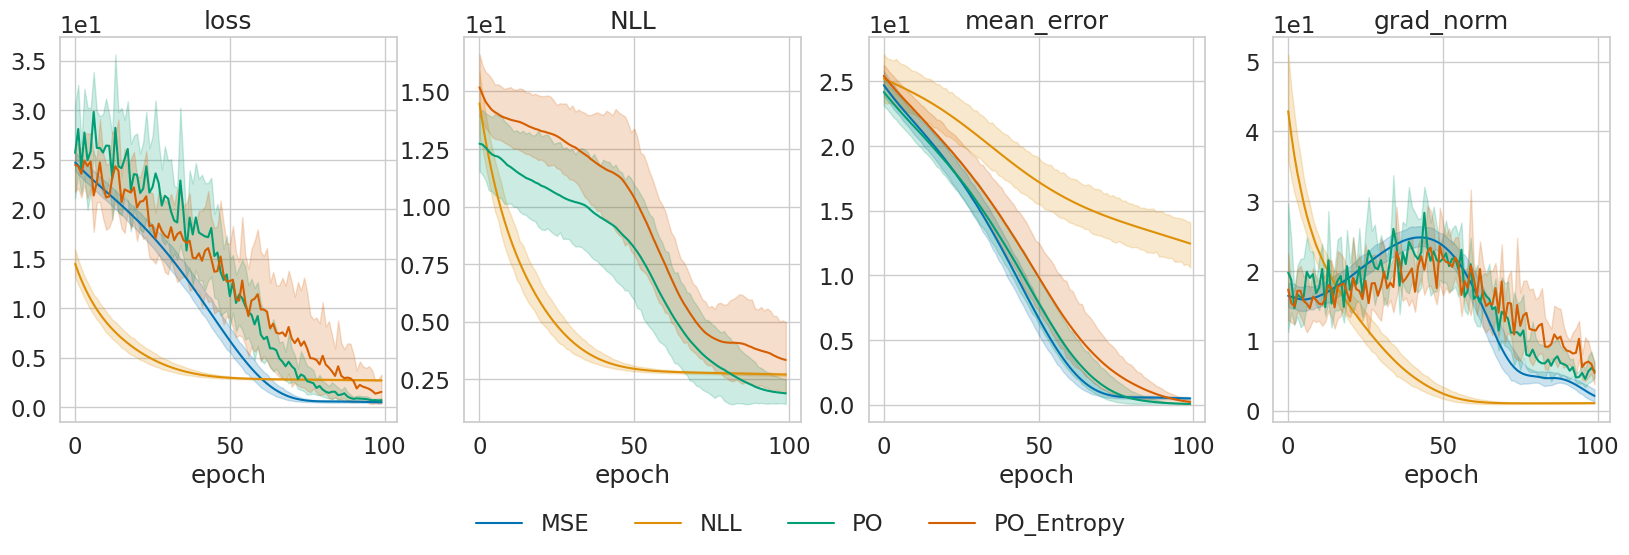

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
    sns.lineplot(
        data=df_all,
        x="epoch",
        y=metric,
        hue="loss_type",
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(metric)
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
ax[0].legend(bbox_to_anchor=(2.2, -0.35), loc="lower center", ncol=4, frameon=False)
plt.show()

### ablations

In [12]:
def plot_ablation(
    df: pd.DataFrame,
    hue_variable: str,
    style_variable: Optional[str] = None,
    loss_type_list: List[str] = [],
    use_rsample_list: List[bool] = [],
    n_generations_list: List[int] = [],
    entropy_weight_list: List[float] = [],
    reward_transform_list: List[str] = [],
):
    sub_df = df.copy()
    if loss_type_list:
        sub_df = sub_df[sub_df["loss_type"].isin(loss_type_list)]
    if use_rsample_list:
        sub_df = sub_df[sub_df["use_rsample"].isin(use_rsample_list)]
    if n_generations_list:
        sub_df = sub_df[sub_df["n_generations"].isin(n_generations_list)]
    if entropy_weight_list:
        sub_df = sub_df[sub_df["entropy_weight"].isin(entropy_weight_list)]
    if reward_transform_list:
        sub_df = sub_df[sub_df["reward_transform"].isin(reward_transform_list)]

    _, ax = plt.subplots(1, 4, figsize=(16, 5))
    for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
        sns.lineplot(
            data=sub_df,
            x="epoch",
            y=metric,
            hue=hue_variable,
            style=style_variable,
            ax=ax[i],
            legend=False if i > 0 else True,
        )
        ax[i].set_ylabel(None)
        ax[i].set_title(metric)
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[0].legend(bbox_to_anchor=(2.5, -0.35), loc="lower center", ncol=4, frameon=False)
    plt.show()

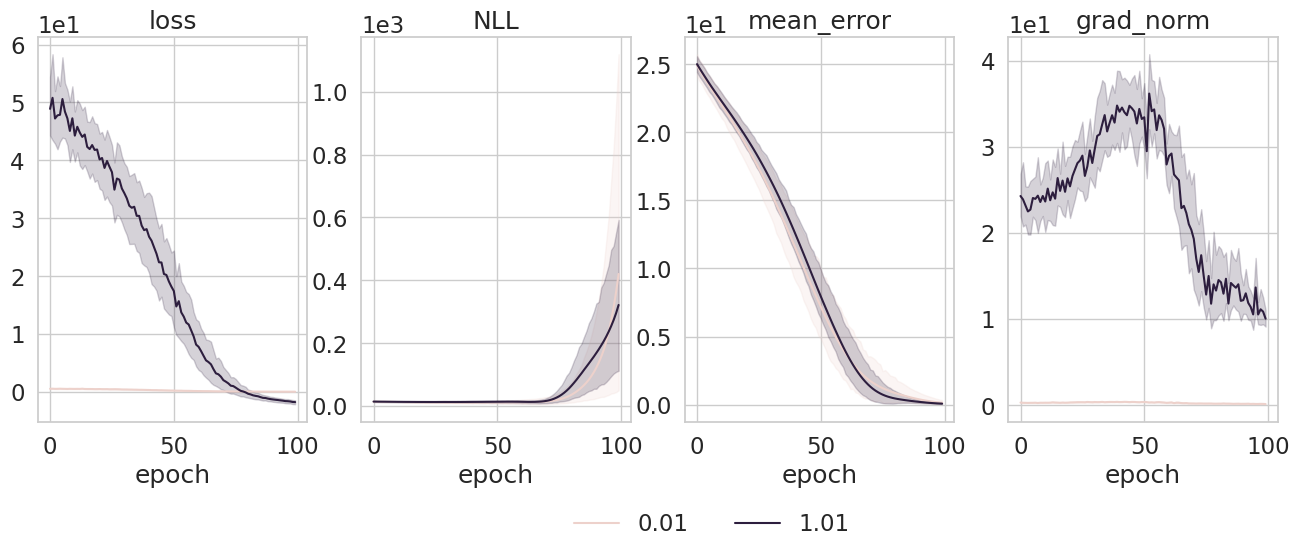

In [13]:
plot_ablation(
    df=df_all,
    hue_variable="entropy_weight",
    style_variable=None,
    loss_type_list=["PO_Entropy"],
    use_rsample_list=[],
    n_generations_list=[],
    entropy_weight_list=[0.01, 1.01],
    reward_transform_list=[],
)